In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from utils import scatter_plot

%load_ext autoreload
%autoreload 2

In [2]:
# Loading HYDRoSWOT dataset 
hydroswot = pd.read_csv('dataset/SWOT_ADCP_Dataset.csv', converters={'site_no': str}, low_memory=False)
hydroswot.shape

(223022, 75)

In [3]:
# Select desired variables and exlcude any non values
candidate_columns=['site_no', 'site_tp_cd', 'q_va', 'stream_wdth_va', 'xsec_area_va', 'mean_depth_va', 'max_depth_va']
df = hydroswot[candidate_columns]
df = df.dropna(axis=0, how='any', subset=candidate_columns)
print(df.shape)

(55240, 7)


In [4]:
# Exclude zero values of all variables
df = df[(df != 0).all(axis=1)]
print(df.shape)

(55231, 7)


In [5]:
# Exclude USGS sites with negative discharge observations
hydro_pos_q = df[df.groupby('site_no')['q_va'].transform(lambda x: (x<0).sum()) == 0]
print(hydro_pos_q.shape)

(49022, 7)


In [6]:
# Keep only sites categorized as channels or streams
hydro_pos_q = hydro_pos_q[hydro_pos_q['site_tp_cd'].isin(['ST'])]
print(hydro_pos_q.shape)

(47522, 7)


In [7]:
# Reset DataFrame index and print the statistics of the unique USGS sites 
hydro_pos_q.reset_index(drop=True, inplace=True)

print("site locations with positive discharge: ")
hydro_pos_q['site_no'].value_counts().describe()

site locations with positive discharge: 


count    5914.000000
mean        8.035509
std        10.050780
min         1.000000
25%         2.000000
50%         4.000000
75%        11.000000
max       159.000000
Name: count, dtype: float64

In [8]:
# Print the statistics of all variables
hydro_pos_q.describe()

,q_va,stream_wdth_va,xsec_area_va,mean_depth_va,max_depth_va
count,4.752200e+04,47522.000000,47522.000000,47522.000000,47522.000000
mean,1.100066e+04,239.193869,3431.116848,6.682162,9.857616
std,5.903527e+04,397.990026,14575.380645,7.269928,10.752993
min,5.300000e-02,2.550000,1.080000,0.520000,0.680000
25%,2.391915e+02,69.230000,195.000250,2.677000,4.085000
50%,8.000850e+02,122.638000,529.430000,4.460000,6.791000
75%,3.128004e+03,244.187250,1585.674250,7.842750,11.407000
max,2.257500e+06,16361.950000,357000.000000,118.770000,205.670000


Thalweg Calculation

In [16]:
# Imperial unit
x = (hydro_pos_q['mean_depth_va']).to_numpy()
y = (hydro_pos_q['max_depth_va']).to_numpy()

# Convert the variable units into SI
x_si = (hydro_pos_q['mean_depth_va']*0.3048).to_numpy()
y_si = (hydro_pos_q['max_depth_va']*0.3048).to_numpy()

# Estimate the model parameters
print(f'Slope: {np.std(y) / np.std(x):.4f}')
print(f'Intercept: {np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x):.4f} (Imperial) \
      {np.mean(y_si) - (np.std(y_si) / np.std(x_si)) * np.mean(x_si):.4f} (SI)')

Slope: 1.4791
Intercept: -0.0260 (Imperial)       -0.0079 (SI)


In [10]:
# Convert the variable units into SI
x = (hydro_pos_q['mean_depth_va']).to_numpy()
y = (hydro_pos_q['max_depth_va']).to_numpy()

# Estimate the model parameters
print(f'slope:{np.std(y) / np.std(x):.4f}')
print(f'intercept:{np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x):.4f}')

slope:1.4791
intercept:-0.0260


test size: (47522,), pred size: (47522,)
NSE: 0.9375, r: 0.9688, PBias: 3.17E-14, RMSE: 0.8193


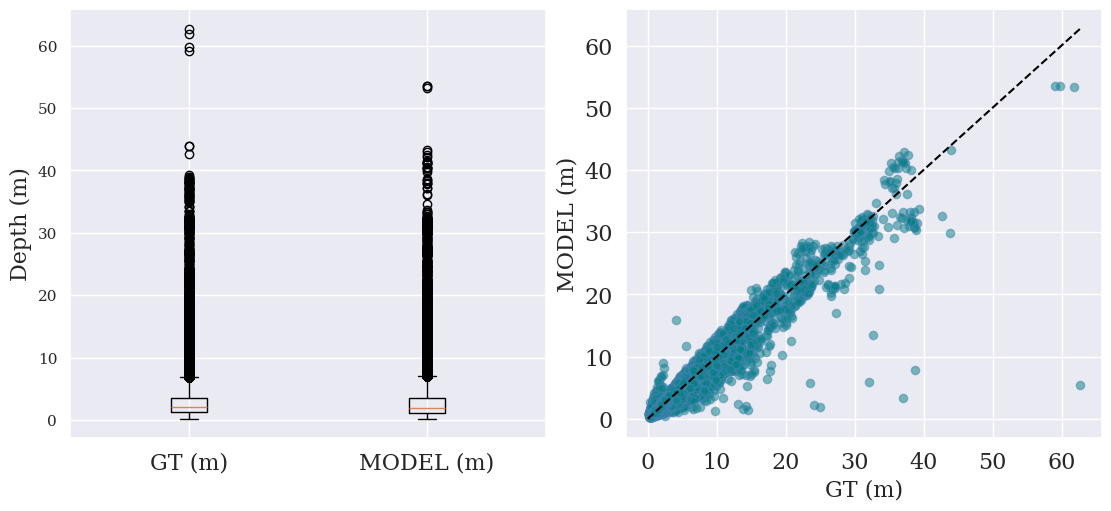

In [10]:
# Calculate model outputs and plot agains GTs
y_pred = (np.std(y) / np.std(x) * x) + (np.mean(y) - (np.std(y) / np.std(x)) * np.mean(x))
scatter_plot(y, y_pred, model_name='depth-max')